In [1]:
!pip install diffusers==0.30.0
!pip install transformers scipy  ftfy accelerate opencv-python mediapipe
!pip install -U controlnet-aux

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 35.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)

/content/drive/MyDrive/Colab Notebooks/인사교_머신러닝/DL (딥러닝)


#### ControlNet
- Stable Diffusion의 응용
  - 프롬프트뿐만 아니라, 특정한 조건 추가해서 이미지 생성을 제어하는 기술
  

In [5]:
from diffusers.utils import load_image, make_image_grid # 이미지 로드, 이미지 그리드 형태로 출력하는 도구
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers import StableDiffusionControlNetInpaintPipeline # 인페인팅 전용 파이프라인
from controlnet_aux import OpenposeDetector # 관절 키포인트 추출하는데 사용되는 도구

import torch
from PIL import Image
import cv2
import numpy as np

#### Inpainting
- 이미지 처리 기술 중 하나
- 손상 된 이미지 영역을 복원하거나, 삭제된 부분을 채워주는 기술


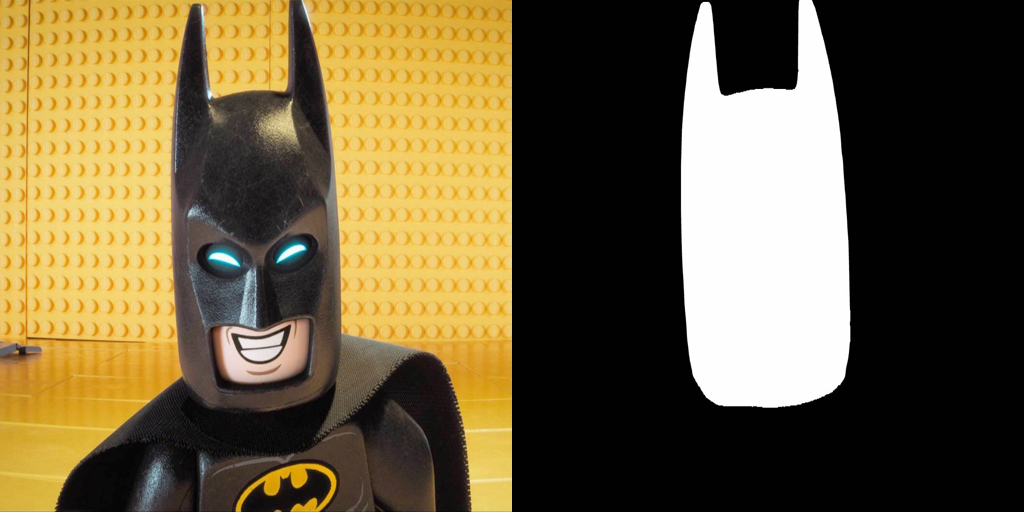

In [6]:
# 원본이미지
init_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet-inpaint.jpg"
)

init_image = init_image.resize((512, 512))

# 마스크 이미지
mask_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/controlnet-inpaint-mask.jpg"
)

mask_image = mask_image.resize((512, 512))

make_image_grid([init_image, mask_image], rows = 1, cols = 2)

In [8]:
# 컨디션 이미지(조건 이미지)를 생성하는 함수 정의
def make_inpaint_condition(image, image_mask):
    # RGB로 채널 변환 후, 0 ~ 1 사이로 정규화
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0

    # L -> 그레이 스케일로 변환 후, 0 ~ 1 사이로 정규화
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1] # 원본이미지랑 마스크 이미지랑 높이와 너비가 같은지 확인

    # 이밈지에서 값이 0.5보다 큰 위치(마스크 영역)에 해당하는 원본 이미지의 픽셀값을 -1.0으로 설정
    image[image_mask > 0.5] = -1.0
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2) # 차원 순서를 (배치, 채널, 높이, 너비)로 변경
    image = torch.from_numpy(image) # 텐서 형으로 변환
    return image

In [9]:
control_image = make_inpaint_condition(init_image, mask_image)

In [10]:
# ControlNet 모델을 사전 학습 된 체크포인트 로드
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint", # 인페인트용 모델
    torch_dtype = torch.float16, # 메모리 사용량을 줄이기 위함
    use_safetensors = True # 성능 향상(내 메모리로 직접 로드함)
)

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [12]:
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "sd-legacy/stable-diffusion-v1-5", # 1.5v 경로
    controlnet = controlnet,
    safety_checker = None,
    torch_dtype = torch.float16, # 메모리 사용량을 줄이기 위함
    use_safetensors = True # 성능 향상(내 메모리로 직접 로드람)
)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look 

In [13]:
# 스케줄러 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [14]:
pipe.enable_model_cpu_offload() # GPU 메모리가 부족할 때 CPU로 일부 이동시켜서 성능 향상

In [28]:
# 이미지 생성
prompt = "(Welsh Corgi:1.1), big ears, (face:1.5), Fill with faces only, best quality, extremely detailed"

# 생성 시 제외할 요소들을 지정하는 네거티브 프롬프트
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality, full body shot"

# 시드 고정
generator = torch.Generator("cuda").manual_seed(2024)

output = pipe(
    prompt,
    num_inference_steps = 80,
    eta = 1.0, # 다양성 조정 파라미터
    image = init_image,
    mask_image = mask_image,
    control_image = control_image, # 컨디션 이미지(조건 이미지)
    generator = generator,
    negative_prompt = negative_prompt
).images[0]

  0%|          | 0/80 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


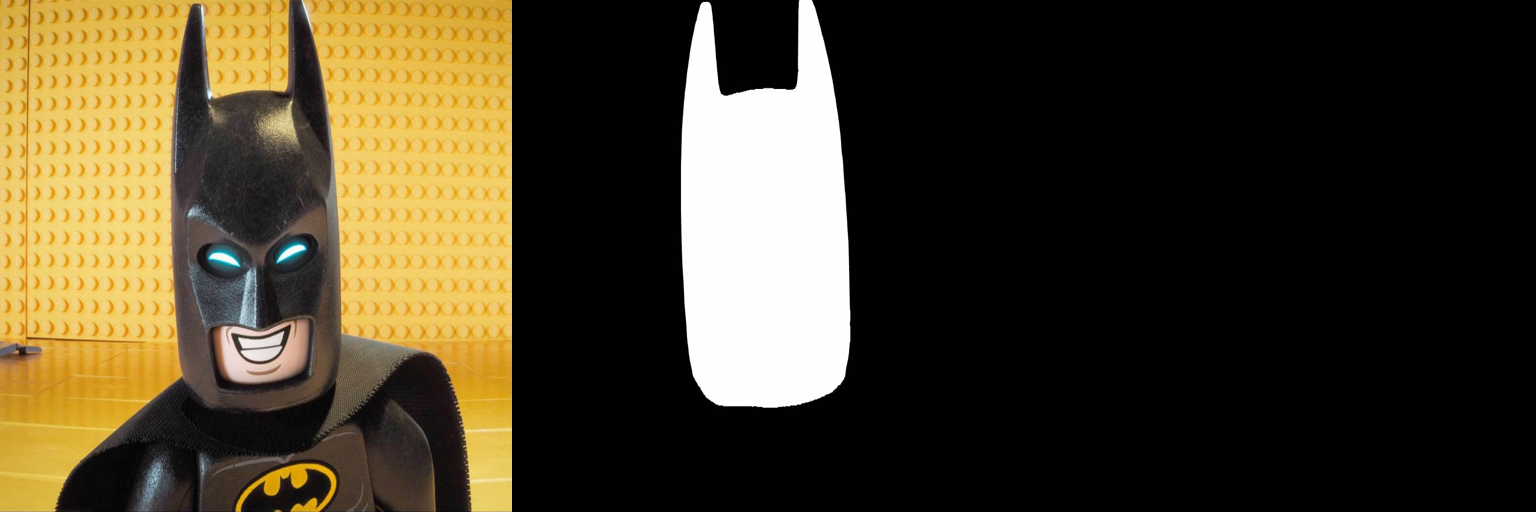

In [29]:
make_image_grid([init_image, mask_image, output], rows = 1, cols = 3)


#### OpenPose
- openpose : 골격(관절 키 포인트)

In [18]:
# url에서 이미지 로드
original_image = load_image("https://as1.ftcdn.net/v2/jpg/01/07/18/36/1000_F_107183617_94DPRLIMXP9VK227OiIX8W5dNhVZIpCI.jpg")

In [20]:
# 관절 키 포인트 추출

openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet") # 사전 학습 된 관절 탐지기 로드

openpose_image = openpose(original_image) # 키 포인트 추출

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

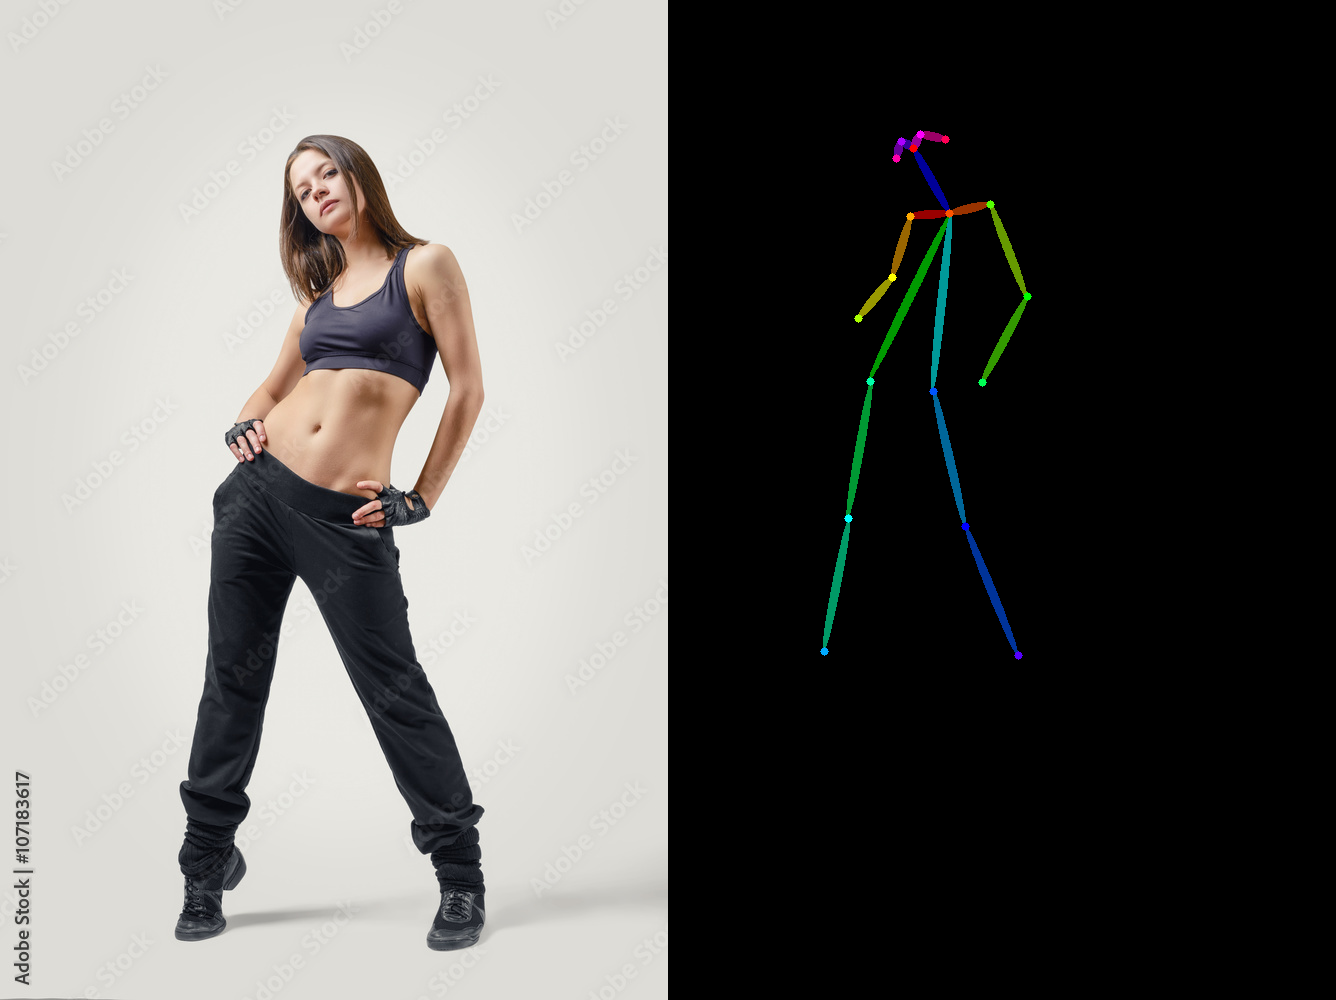

In [21]:
make_image_grid([original_image, openpose_image], rows = 1, cols = 2)

In [22]:
# ControlNet 모델을 사전 학습 된 체크포인트 로드
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose", # 오픈포즈용 모델
    torch_dtype = torch.float16, # 메모리 사용량을 줄이기 위함
    use_safetensors = True # 성능 향상(내 메모리로 직접 로드함)
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

In [24]:
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "sd-legacy/stable-diffusion-v1-5",
    controlnet = controlnet,
    torch_dtype = torch.float16, # 메모리 사용량을 줄이기 위함
    use_safetensors = True # 성능 향상(내 메모리로 직접 로드함)
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [25]:
# 스케줄러 설정
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

pipe.enable_model_cpu_offload() # GPU 메모리가 부족할 때 CPU로 일부 이동시켜서 성능 향상

In [26]:
# 이미지 생성
prompt = "super-hero character, best quality, extremely detailed"

# 생성 시 제외할 요소들을 지정하는 네거티브 프롬프트
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low qualityt"

# 시드 고정
generator = torch.Generator("cuda").manual_seed(2024)

output = pipe(
    prompt,
    image = openpose_image,
    num_inference_steps = 80,
    generator = generator,
    negative_prompt = negative_prompt
).images[0]

  0%|          | 0/80 [00:00<?, ?it/s]

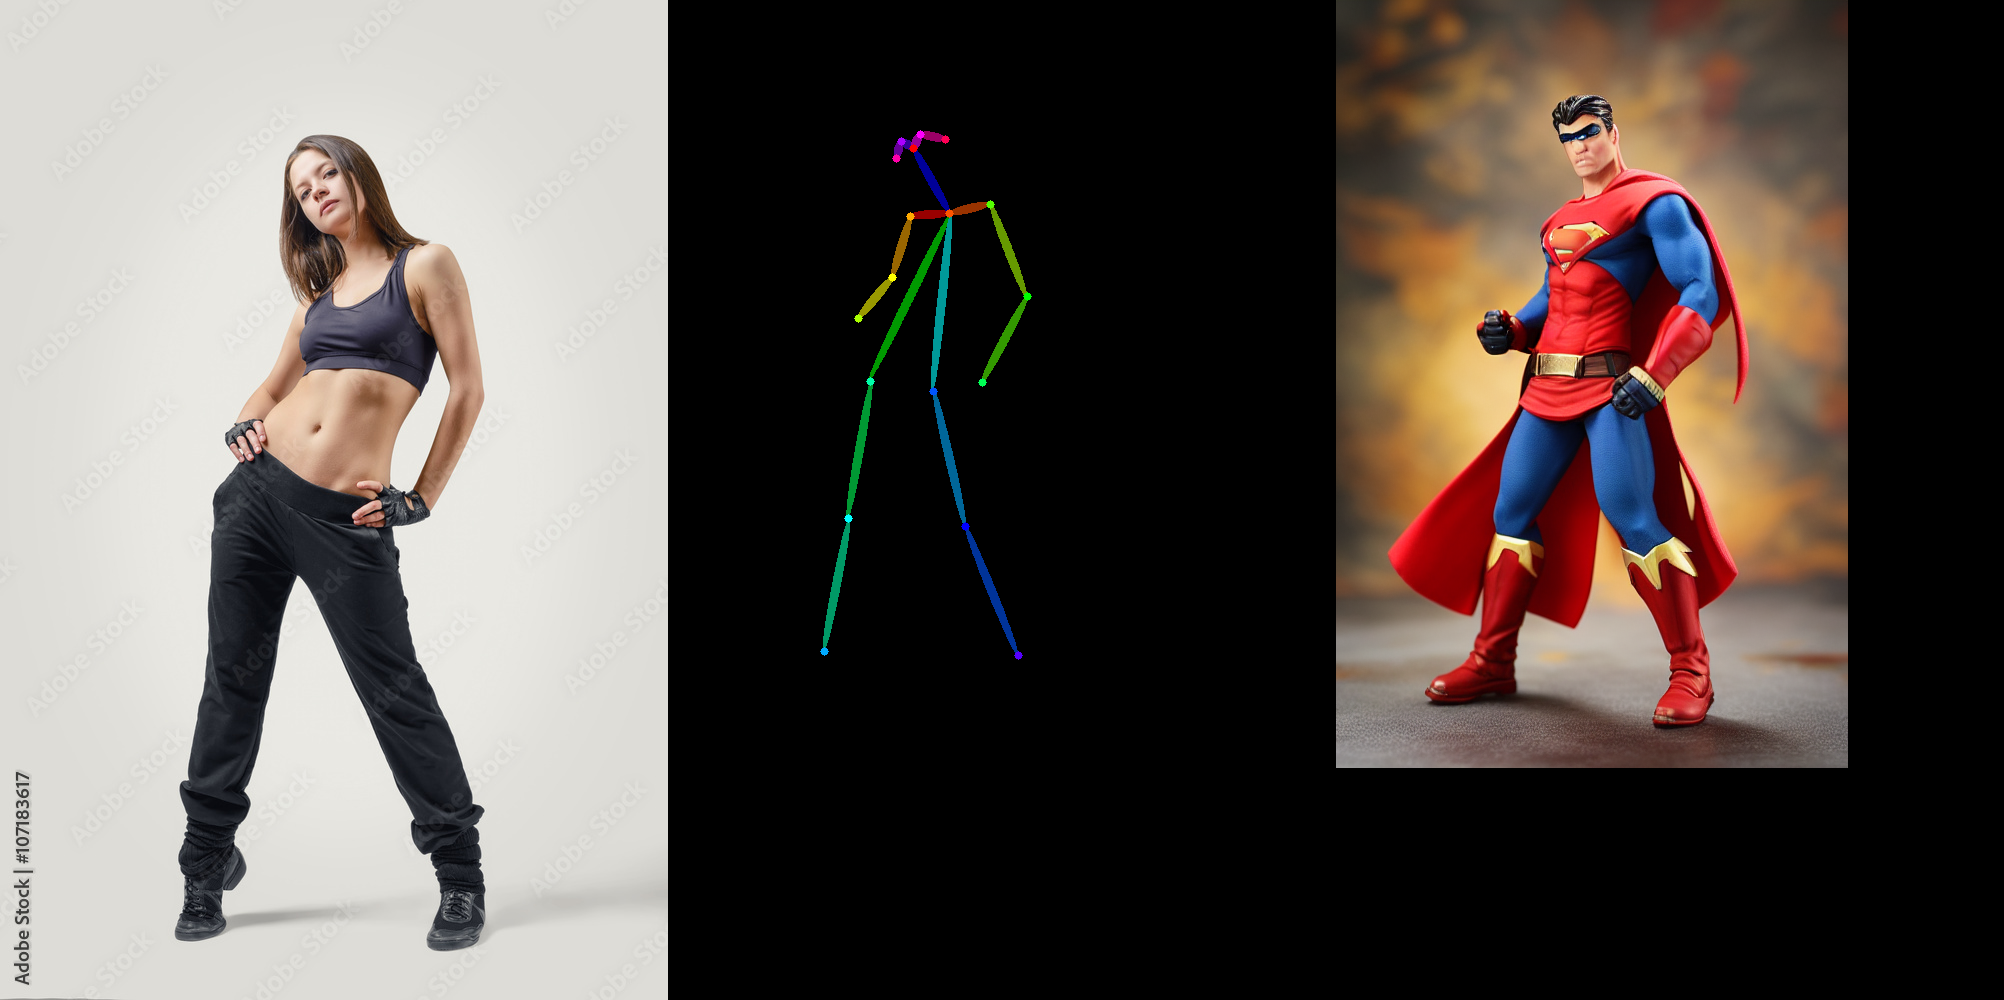

In [27]:
make_image_grid([original_image, openpose_image, output], rows = 1, cols = 3)